In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
! pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 30.2 MB/s eta 0:00:00


In [ ]:
# 구글 드라이브 마운트 (파일 경로에 맞게 설정하세요)
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# 한국어 데이터
from konlpy.tag import Okt
okt = Okt()

In [ ]:
# 1. 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/AI_Contest/ACK/Emotion_filtered.csv', encoding='cp949')

# 2. 데이터 전처리
sentences = data['Sentence'].values
labels = data['Emotion'].values

In [ ]:
stopwords = ['은', '는', '이', '가', '을', '를', '에', '의', '도', '다']

def tokenize(text):
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in stopwords]
    return tokens

tokenized_texts = [tokenize(text) for text in sentences]

In [ ]:
! pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
from nlpaug.augmenter.word import SynonymAug

In [ ]:
# 3. 텍스트 증강을 위한 nlpaug의 SynonymAug 사용
aug = SynonymAug(aug_src='wordnet')  # 'wordnet'으로 한국어 증강이 제한될 수 있으니, 다른 방법 필요 시 고려

# 원본 문장 증강
augmented_sentences = [aug.augment(' '.join(sentence)) for sentence in tokenized_texts]  # 토큰을 다시 문장으로 변환 후 증강

# 4. 증강된 데이터 추가
augmented_sentences = [' '.join(sent) for sent in augmented_sentences]  # 증강된 토큰을 다시 결합
tokenized_texts += augmented_sentences  # 원본 + 증강 데이터 결합
labels_augmented = np.concatenate([labels, labels])  # 증강된 문장은 동일한 레이블 사용

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# 5. 텍스트를 숫자로 변환 (Tokenization)
tokenizer = Tokenizer(num_words=15000)  # 단어 최대 개수
tokenizer.fit_on_texts(tokenized_texts)
sequences = tokenizer.texts_to_sequences(tokenized_texts)

# 패딩 (Padding) - 입력 길이를 동일하게 맞추기
max_len = 14  # 문장의 최대 길이
X = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# 라벨 인코딩 및 원-핫 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_augmented)

In [ ]:
# 데이터셋을 학습셋과 검증셋으로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
def model_fn(a_layer=None):
    model = Sequential()
    model.add(Embedding(input_dim=15000, output_dim=128, input_length=max_len))
    model.add(Bidirectional(LSTM(256, return_sequences=True))) # 양방향으로 변경
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))

    if a_layer:
        model.add(a_layer)
    model.add(Dense(7, activation='softmax'))
    return model

In [ ]:
model = model_fn()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.0001)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.8072 - loss: 0.5719 - val_accuracy: 0.6933 - val_loss: 1.0038
Epoch 2/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.8141 - loss: 0.5480 - val_accuracy: 0.6973 - val_loss: 1.0234
Epoch 3/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8214 - loss: 0.5253 - val_accuracy: 0.6992 - val_loss: 1.0273
Epoch 4/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8306 - loss: 0.5038 - val_accuracy: 0.7075 - val_loss: 1.0262
Epoch 5/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8394 - loss: 0.4760 - val_accuracy: 0.7150 - val_loss: 1.0560
Epoch 6/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.8460 - loss: 0.4525 - val_accuracy: 0.7187 - val_loss: 1.0307
Epoch 7/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8517 - loss: 0.4369 - val_accuracy: 0.7233 - val_loss: 1.0491
Epoch 8/100
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 

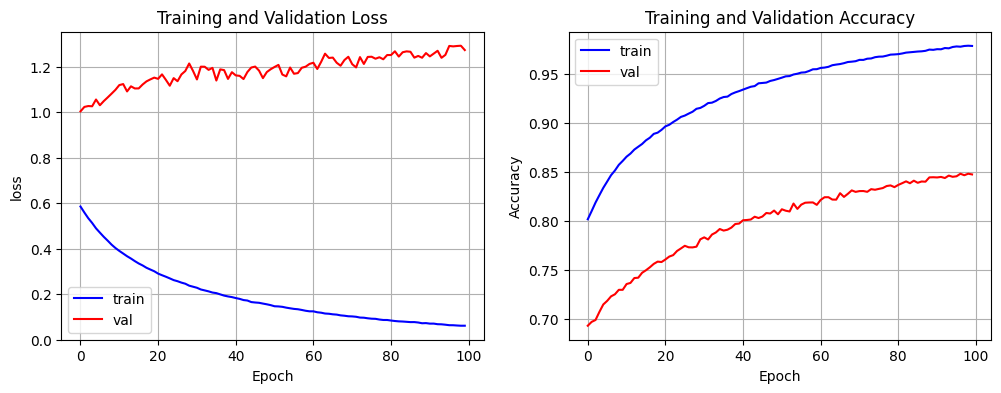

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=64, verbose=1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"],color="blue", label="train")
plt.plot(history.history["val_loss"],color="red", label="val")
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"],color="blue", label="train")
plt.plot(history.history["val_accuracy"],color="red", label="val")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# 모델 평가
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy*100:.2f}%")

1055/1055 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8455 - loss: 1.2465
Test Accuracy: 84.56%


In [ ]:
model.save('BEST_100_emotion_classification.keras')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from keras.models import load_model

# 모델 로드
model = load_model("/content/drive/MyDrive/AI_Contest/ACK/BEST_100_emotion_classification_lstm.keras")
# 모델 요약 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 14, 128)             │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 14, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,219,415 (38.98 MB)

 Trainable params: 3,406,471 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,812,944 (25.99 MB)

멜론 data 예측

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 모델 로드 (Google Drive에 저장된 모델 경로 지정)
model_path = '/content/drive/MyDrive/AI_Contest/BEST_emotion_classification_lstm.keras'
model = tf.keras.models.load_model(model_path)

# CSV 파일 로드 (Google Drive에 저장된 파일 경로 지정)
csv_path = '/content/drive/MyDrive/AI_Contest/melon_gerne_top50_bpm_filtered.csv'
data = pd.read_csv(csv_path)

# 'Filtered_Description' 열 추출
texts = data['Filtered_Description'].values

# 텍스트 전처리 (Tokenizer와 시퀀스로 변환)
tokenizer = Tokenizer(num_words=10000)  # 사용할 단어 수를 제한
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 패딩을 사용하여 시퀀스 길이를 맞춤
maxlen = 100  # 예시로 시퀀스의 최대 길이를 100으로 설정
input_data = pad_sequences(sequences, maxlen=maxlen)

# 예측 수행
predictions = model.predict(input_data)

emotion_labels = {0 : '불안', 1 : '슬픔', 2 : '당황', 3 : '기쁨', 4 : '분노', 5 : '상처', 6 : '중립'}

# 예측 결과 해석 (클래스 라벨이 있는 경우)
predicted_classes = np.argmax(predictions, axis=1)
predicted_emotions = [emotion_labels[label] for label in predicted_classes]

data['Predicted_Emotion'] = predicted_emotion

# 결과 출력
print(data[['Title', 'Artist', 'Predicted_Emotion']])

# 예측 결과를 파일로 저장하고 Google Drive에 저장
output_file_path = '/content/drive/MyDrive/AI_Contest/predictions_output_with_emotions.csv'
data.to_csv(output_file_path, index=False)

print(f"결과가 저장되었습니다: {output_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
                Title          Artist Predicted_Emotion
0                 소나기  이클립스 (ECLIPSE)                기쁨
1                 천상연             이창섭                기쁨
2         미안해 미워해 사랑해           Crush                기쁨
3       Love wins all             아이유                당황
4              비의 랩소디             임재현                기쁨
..                ...             ...               ...
345              돼지토끼             장윤정                기쁨
346       깜빡이를 키고 오세요             박지현                기쁨
347             안동역에서              진성                기쁨
348  산다는 건 (Cheer Up)             홍진영                상처
349                백야             손태진                슬픔

[350 rows x 3 columns]
결과가 저장되었습니다: /content/drive/MyDrive/AI_Contest/predictions_output_with_emotions.csv


In [ ]:
import pandas as pd

# CSV 파일 로드 (Google Drive에 저장된 파일 경로 지정)
csv_path = '/content/drive/MyDrive/AI_Contest/predictions_output_with_emotions.csv'
data = pd.read_csv(csv_path)

# 각 감정의 개수를 세기
emotion_counts = data['Predicted_Emotion'].value_counts()

# 결과 출력
print(emotion_counts)


Predicted_Emotion
기쁨    122
당황     66
상처     45
불안     44
분노     34
슬픔     24
중립     15
Name: count, dtype: int64
